# Goal

Use ML to **identify animal species** from rainforest sounds, despite limited data, to help save biodiversity in one of the most endangered rainforest regions of Colombia.

In [1]:
import numpy as np
import pandas as pd
import os

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy

In [3]:
# For audio loading and inspection
import librosa
import librosa.display
from IPython.display import Audio

In [4]:
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# 1. Dataset Exploration & Exploratory Data Analysis

## 1.1 Data files structure

In [5]:
# /kaggle/input/birdclef-2025/sample_submission.csv
# /kaggle/input/birdclef-2025/taxonomy.csv
# /kaggle/input/birdclef-2025/train.csv
# /kaggle/input/birdclef-2025/recording_location.txt
# /kaggle/input/birdclef-2025/train_audio/greani1/XC132190.ogg
# .....
# /kaggle/input/birdclef-2025/train_soundscapes/H74_20230423_200500.ogg
# .....
# /kaggle/input/birdclef-2025/test_soundscapes/readme.txt

In [6]:
BASE_DIR = r'/kaggle/input/birdclef-2025/'

## 1.2 Loading `train_metadata.csv` into a pandas DataFrame.



In [7]:
train_df = pd.read_csv(os.path.join(BASE_DIR, 'train.csv'))
train_df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0


In [8]:
train_df.columns

Index(['primary_label', 'secondary_labels', 'type', 'filename', 'collection',
       'rating', 'url', 'latitude', 'longitude', 'scientific_name',
       'common_name', 'author', 'license'],
      dtype='object')

In [9]:
taxonomy_df = pd.read_csv(os.path.join(BASE_DIR, 'taxonomy.csv'))

In [10]:
taxonomy_df.head()

,primary_label,inat_taxon_id,scientific_name,common_name,class_name
0,1139490,1139490,Ragoniella pulchella,Ragoniella pulchella,Insecta
1,1192948,1192948,Oxyprora surinamensis,Oxyprora surinamensis,Insecta
2,1194042,1194042,Copiphora colombiae,Copiphora colombiae,Insecta
3,126247,126247,Leptodactylus insularum,Spotted Foam-nest Frog,Amphibia
4,1346504,1346504,Neoconocephalus brachypterus,Neoconocephalus brachypterus,Insecta


## 1.3 Exploring label distribution (head/tail species)

In [11]:
# Primary Label Distribution
label_counts = train_df['common_name'].value_counts()
print("\nNumber of unique species:", label_counts.shape[0])


Number of unique species: 206


In [12]:
print("Any inf:", np.isinf(label_counts.values).any())
print("Any NaN:", np.isnan(label_counts.values).any())

Any inf: False
Any NaN: False


In [13]:
label_counts

common_name
Great Kiskadee                     990
Common Pauraque                    808
Tropical Kingbird                  787
Roadside Hawk                      709
Bananaquit                         610
                                  ... 
Colombian Plump Frog                 2
Brown-throated Three-toed Sloth      2
Collared Peccary                     2
Crab-eating Fox                      2
Ragoniella pulchella                 2
Name: count, Length: 206, dtype: int64

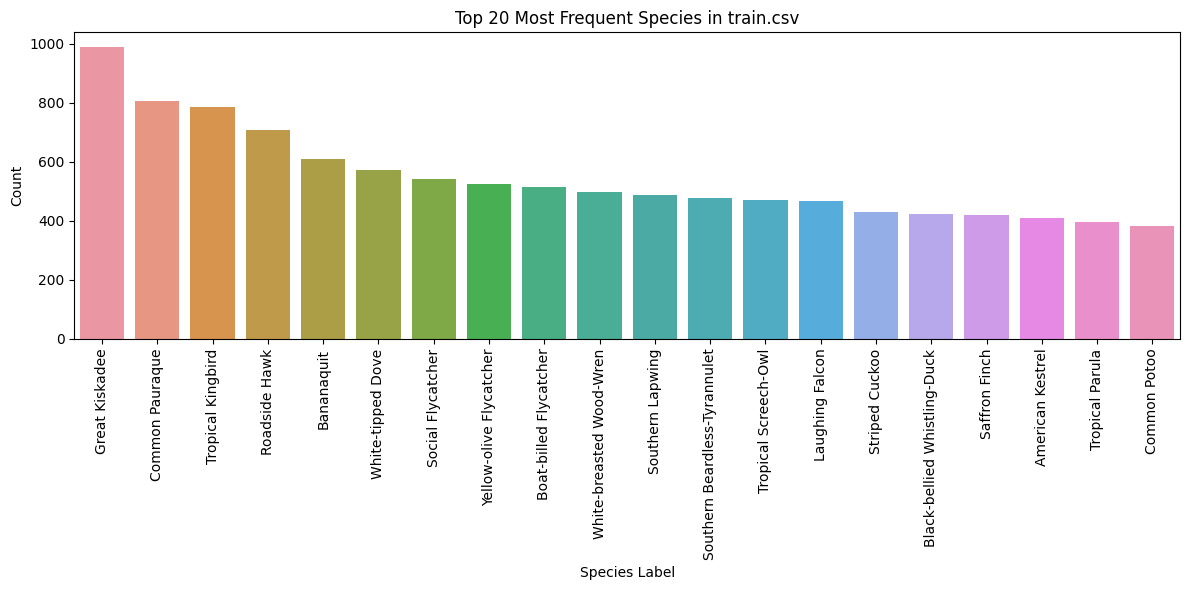

In [14]:
# Show top 20 most frequent labels
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.iloc[:20].index, y=label_counts.iloc[:20].values)
plt.title('Top 20 Most Frequent Species in train.csv')
plt.xlabel('Species Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

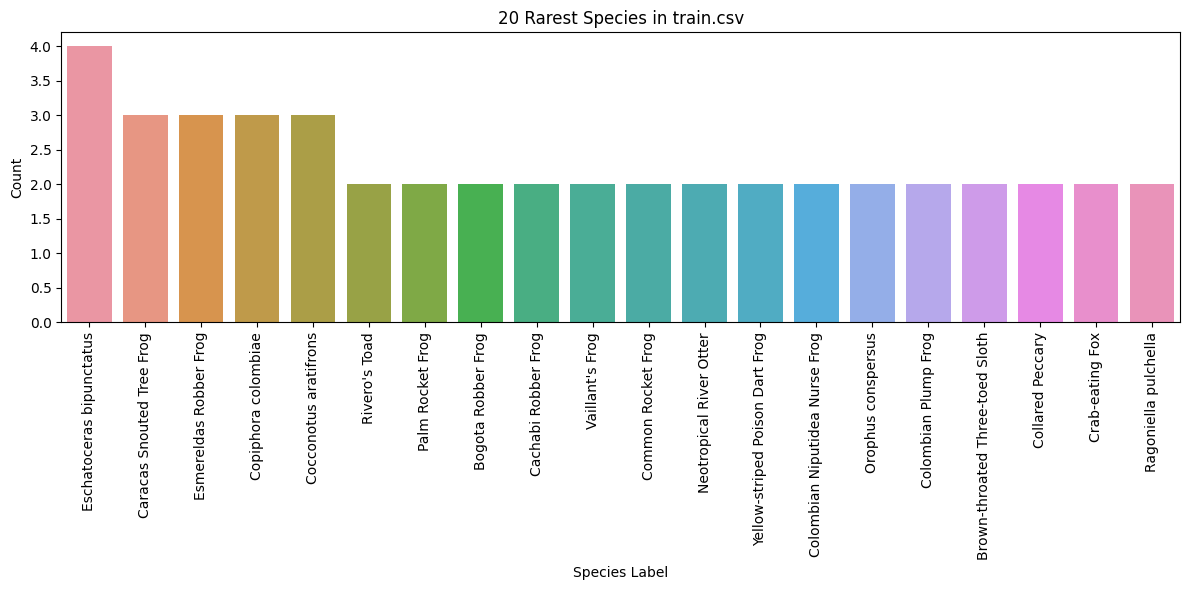

In [15]:
# Show bottom 20 least frequent labels
plt.figure(figsize=(12, 6))
sns.barplot(x=label_counts.iloc[-20:].index, y=label_counts.iloc[-20:].values)
plt.title('20 Rarest Species in train.csv')
plt.xlabel('Species Label')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 1.4 Visualize class imbalance

### 1.4.1 Class Distribution Histogram

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


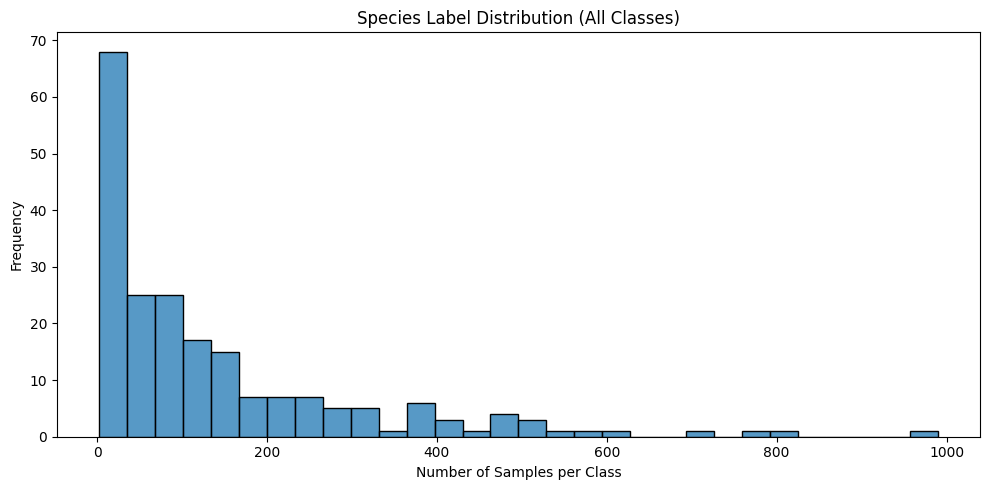

In [16]:
# Class Distribution Histogram
plt.figure(figsize=(10, 5))
sns.histplot(label_counts.values, bins=30, kde=False)
plt.title('Species Label Distribution (All Classes)')
plt.xlabel('Number of Samples per Class')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
# Warning - purely from seaborn's internal logic

**What Does the Histogram Show?**
The histogram of `labels_count.values` tells how many classes (species) have a certain number of training samples. It a plot of the frequency of frequencies.

**Questions to be answered from the Histogram**
1. How imbalanced is the dataset?
2. Are there many rare classes (e.g. with <5 samples)?
3. Are there a few dominant classes (e.g. with >100 samples)?
4. Is it a long-tail distribution (common in bioacoustic data)?

In [17]:
# 1. How imbalanced is the dataset?
# CIR - Ratio of the largest to the smallest class.
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"Class Imbalance Ratio (max/min) [CIR]: {imbalance_ratio:.2f}")

Class Imbalance Ratio (max/min) [CIR]: 495.00


**A huge skew** - the most frequent species occurs 495x more often than the rarest.

Rule of thumb:
* CIR < 10 → Mild imbalance
* CIR 10–50 → Moderate imbalance
* CIR > 100 → **Severe imbalance**




In [18]:
# 2. Are there many rare classes (e.g. with <5 samples)?
# Defining a threshold of n < 5 and counting how many / % of classes that fall below.
num_rare_classes = (label_counts < 5).sum()
rare_class_percent = 100 * num_rare_classes / len(label_counts)
print(f"Rare classes % (<5 samples): {num_rare_classes} ({rare_class_percent:.1f}%)")

Rare classes % (<5 samples): 23 (11.2%)



* ~23 out of 206 classes have fewer than 5 samples
* Suggests a **long-tail distribution**, and may require special techniques like:
    * Stratified sampling
    * Data augmentation
    * Few-shot learning
    * Class-balanced loss functions

In [19]:
# 3. Gini Coefficient
# Measuring statistical dispersion (0 = perfect equality, 1 = max inequality)
def gini(array):
    array = np.sort(array)
    n = len(array)
    index = np.arange(1, n + 1)
    return (2 * np.sum(index * array) / (n * np.sum(array))) - (n + 1) / n

gini_coeff = gini(label_counts.values)
print(f"Gini Coefficient: {gini_coeff:.3f}")

Gini Coefficient: 0.590



* Range: 0 (perfectly equal) → 1 (max inequality)
* Measures distribution inequality of class frequencies
* Typical interpretations:
    * Gini < 0.3 → Low imbalance
    * Gini ≈ 0.5 → Medium imbalance
    * Gini > 0.6 → Severe imbalance
  
0.59 suggests borderline moderate-to-severe imbalance

In [20]:
# 4. Entropy of Label Distribution
# Higher = more uniform distribution
label_probs = label_counts / label_counts.sum()
entropy_val = entropy(label_probs) # from scipy.stats import entropy
print(f"Label distribution entropy: {entropy_val:.3f}")

Label distribution entropy: 4.722


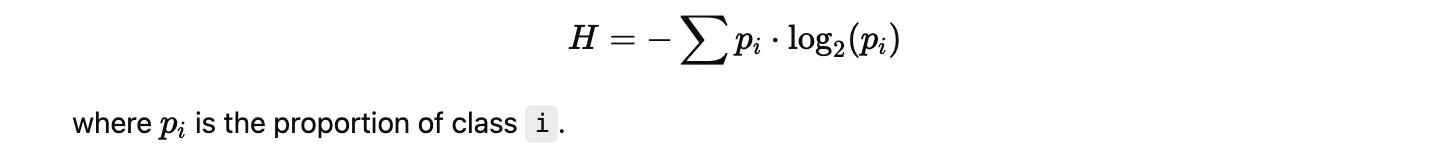
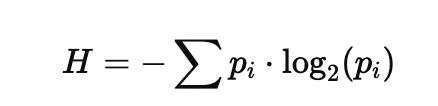
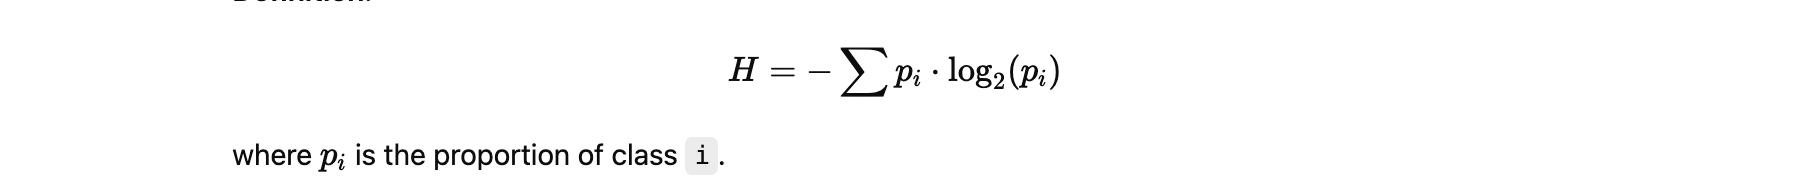

**Maximum value:**
For 206 classes, max entropy = `log2(206)≈7.7`

**Interpretation:**
* Closer to max → uniform label distribution
* Closer to 0 → highly skewed distribution
* 4.722 / 7.7 ≈ 61% of max entropy ⇒ **Moderately imbalanced**

| Metric  | Value | Interpretation               |
| ------- | ----- | ---------------------------- |
| CIR     | 495   | **Extremely Imbalanced**     |
| Gini    | 0.590 | Moderate-to-Severe Imbalance |
| Entropy | 4.72  | Moderate Diversity           |
| Rare %  | 11.2% | Long-tail Warning            |

### 1.4.2 More Analytical Histogram

* **Bar Widths**: Fewer bins → wider bars, so frequent sample sizes (e.g. 5, 10, 20) get merged into one bar. Finer binning gives a clearer shape of the tail.

* **Y-axis log scale**: In a long-tail setting, most species occur with very few samples. The log scale makes those visible instead of being crushed at the bottom.

* **Interpretability**: With log-scale, one can detect power-law behavior (e.g. Zipfian distribution), which is common in biodiversity and natural language.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


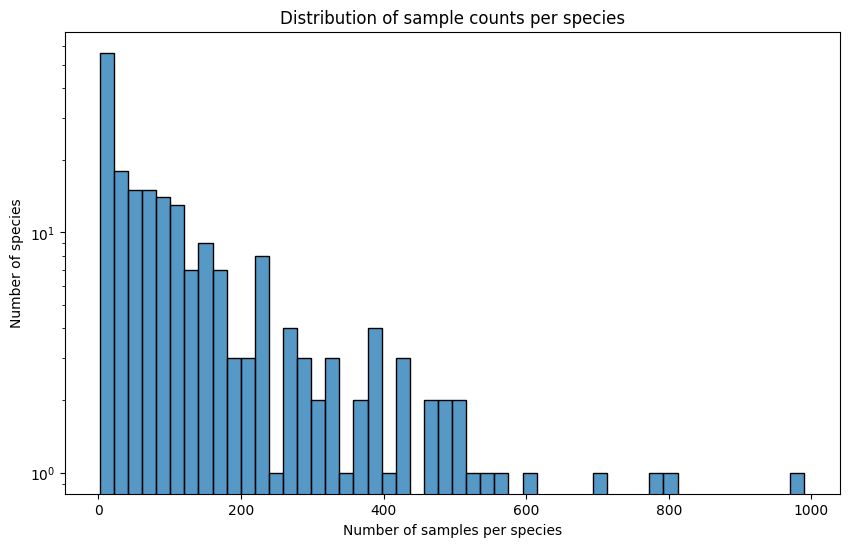

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.histplot(label_counts.values, bins=50, log_scale=(False, True))
plt.xlabel("Number of samples per species")
plt.ylabel("Number of species")
plt.title("Distribution of sample counts per species")
plt.show()

### 1.4.3 Log-Log Plot (Long-Tail Signature)

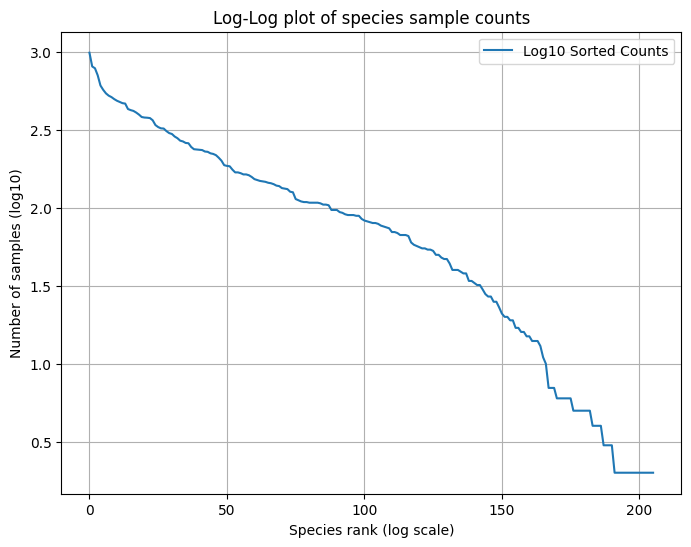

In [22]:
plt.figure(figsize=(8, 6))
sorted_counts = np.sort(label_counts.values)[::-1]
plt.plot(np.log10(sorted_counts), label='Log10 Sorted Counts')
plt.xlabel("Species rank (log scale)")
plt.ylabel("Number of samples (log10)")
plt.title("Log-Log plot of species sample counts")
plt.grid(True)
plt.legend()
plt.show()

If this curve is steep and drops quickly, you’re definitely in long-tail territory.

* A steep curve, in general, refers to a curve that rises or falls at a sharp angle, making it difficult to navigate or climb

| Metric                | Interpretation                               |
| --------------------- | -------------------------------------------- |
| Class Imbalance Ratio | How skewed is the most vs least common class |
| Rare Class %          | Fraction of classes with too few examples    |
| Gini Coefficient      | 0 = uniform, 1 = total inequality            |
| Entropy               | Higher = more uniform                        |
| Log-log plot          | Classic visual check for long tail           |


In [23]:
# Save top/bottom labels for re-use
# head_labels = label_counts.head(20).index.tolist()
# tail_labels = label_counts.tail(20).index.tolist()

## 1.5 Load & plot a few `.ogg` files from `train_audio/` using `librosa`

In [24]:
!pip install librosa soundfile

## 1.6 Map a few `primary_labels` to taxonomy with `taxonomy.csv`

 log-mel spectrogram preprocessing and Dataset creation 🔊📈.

**Action Point**: Likely need **class imbalance mitigation** during training — revisit this later with loss weighting, focal loss, and balanced sampling.

Listen to a few audio files using IPython.display.Audio.

Plot waveform & spectrograms for 2–3 samples using librosa or torchaudio.